# NJ Transit + Amtrak (NEC) Rail Performance Business Solution

The busiest passenger rail line in the United States, Amtrak also operates passenger rail service; together the NJ Transit and Amtrak operate nearly 750 trains across the NJ Transit rail network. Our data originates from here; https://www.kaggle.com/pranavbadami/nj-transit-amtrak-nec-performance. This data is organized into a monthly performance report of nearly every train trip on the rail network with the features; date, train ID, stop sequence, station train is traveling from, station ID of train origin, station train is traveling to, train destination ID, scheduled time, actual time, and delay in minutes. We will clean and analyze these features for further machine learning.

The business solution proposed is to create a classification model that can predict when a train is going to be late or not based on the features given. Clustering can also be used to segment rail lines that are in need of increased infrastructure and attention to upgrades to better serve the rail lines and prevent congestion and commute time. The purpose would be to better inform riders in advance of potential delays and cancellation using data driven machine learning algorithms. This would decrease congestion at rail stations where delayed crowds can often stagnate and minimize customer complaints and refunds by giving timelier notice of potential issues. 

I will be using various models and learning methods such as supervised learning (logistic regression, gradient boosting, KNN classifier, decision tree, random forest, SelectKBest, PCA, GridSearchCV hyperparameter tuning), unsupervised learning (t-SNE, PCA, KMeans and DBSCAN clustering) and deep learning models to implement the business solution above.


In [ ]:
# Importing necessary metric and machine learning packages and .csv file into a pandas DataFrame.
%matplotlib inline
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from google.colab import drive
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
import warnings

# Suppress warnings.
warnings.filterwarnings("ignore")

drive.mount('/content/drive')
# Importing rail data from May 2020.
df = pd.read_csv('/content/drive/My Drive/Data/2020_05.csv')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Mounted at /content/drive


# Exploratory Data Analysis and Data Cleaning

In [ ]:
# Examining the first five rows by calling pandas head function.
df.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2020-05-01,5543,1.0,Newark Penn Station,107,Newark Penn Station,107,2020-05-01 23:38:00,2020-05-01 23:40:09,2.150000,departed,Raritan Valley,NJ Transit
1,2020-05-01,5543,2.0,Newark Penn Station,107,Union,38105,2020-05-01 23:47:00,2020-05-01 23:47:01,0.016667,departed,Raritan Valley,NJ Transit
2,2020-05-01,5543,3.0,Union,38105,Roselle Park,31,2020-05-01 23:50:00,2020-05-01 23:51:04,1.066667,departed,Raritan Valley,NJ Transit
3,2020-05-01,5543,4.0,Roselle Park,31,Cranford,32,2020-05-01 23:55:00,2020-05-01 23:55:31,0.516667,departed,Raritan Valley,NJ Transit
4,2020-05-01,5543,5.0,Cranford,32,Westfield,155,2020-05-01 23:59:00,2020-05-01 23:59:01,0.016667,departed,Raritan Valley,NJ Transit


There are a few features of interest here, most notable the delay in minutes column which seems to be a derivative of the scheduled time and actual time features. To_id and from_id correlates to the station names in the to and from columns. The date column spans the month of May

In [ ]:
# Examining DataFrame features data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98698 entries, 0 to 98697
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            98698 non-null  object 
 1   train_id        98698 non-null  object 
 2   stop_sequence   87172 non-null  float64
 3   from            98698 non-null  object 
 4   from_id         98698 non-null  int64  
 5   to              98698 non-null  object 
 6   to_id           98698 non-null  int64  
 7   scheduled_time  87172 non-null  object 
 8   actual_time     98698 non-null  object 
 9   delay_minutes   87172 non-null  float64
 10  status          98698 non-null  object 
 11  line            98698 non-null  object 
 12  type            98698 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 9.8+ MB


Data types seem to be correct for all features, we will further clean our data by dropping unneccesary columns.

In [ ]:
# Dropping to_id and from_id columns from our DataFrame.
df = df.drop(columns='to_id')
df = df.drop(columns='from_id')

Dropping redundant features such as to_id and from_id since our actual locations are listed in features to and from and can be used as dummy variables for easier interpretation. These will also not be useful for analysis.

In [ ]:
# Calling pandas .duplicated function to create boolean series of duplicate values and storing in a pandas DataFrame.
duplicate_rows_df = df[df.duplicated()]
print(duplicate_rows_df.shape)

(0, 11)


Checking DataFrame for rows containing duplicate data, we have only 11 duplicate rows out of 98,000 rows a negligible amount.

In [ ]:
# Finding the percent of missing values by calling pandas .isna function which returns a mask of bool values for each element in 
# DataFrame that indicates whether an element is not an NA value, and rounding the mean.
df.isna().mean().round(4) * 100

date               0.00
train_id           0.00
stop_sequence     11.68
from               0.00
to                 0.00
scheduled_time    11.68
actual_time        0.00
delay_minutes     11.68
status             0.00
line               0.00
type               0.00
dtype: float64

Checking the percentage of missing data in each feature. Stop_sequence, scheduled_time and delay_minutes need to have their missing values dropped for further machine learning. 
These features are missing a significant amount of data, but for the most part our dataset is complete. We will drop the rows that are missing to save the intact information within them.

In [ ]:
# .dropna returns the DataFrame with missing values dropped.
df = df.dropna()

In [ ]:
# Confirming removal of missing values from DataFrame.
df.isna().mean().round(4) * 100

date              0.0
train_id          0.0
stop_sequence     0.0
from              0.0
to                0.0
scheduled_time    0.0
actual_time       0.0
delay_minutes     0.0
status            0.0
line              0.0
type              0.0
dtype: float64

Now that we have cleaned our data we can go ahead and visualize some of the features of interest.

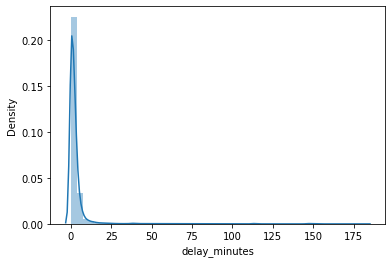

In [ ]:
# Creating distribution plot with seaborn for 'delay_minutes' column.
sns.distplot(df['delay_minutes'])

This plot shows the distribution of our delay in minutes. Most delays were minor, with the highest density either having no delay or about a 5 minute delay. We will use this feature to create our target variable by creating a threshold that will alert to a delay greater than 15 minutes later.

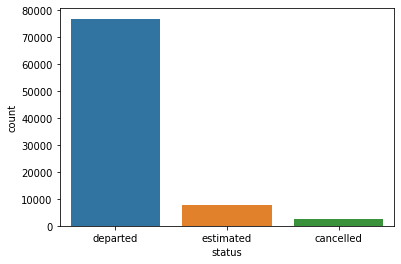

In [ ]:
# Countplot for 'status' with seaborn.
sns.countplot(x ='status', data = df)

This count plot shows train status distribution. A count plot is a histogram across a categorical, instead of quantitative, variable. A majority of trains departed in a timely manner, the trains listed estimated status means they have not explicity departed and may be running late.
Canceled status indicates train has been canceled. We will one-hot encode these variables to run in our machine model.

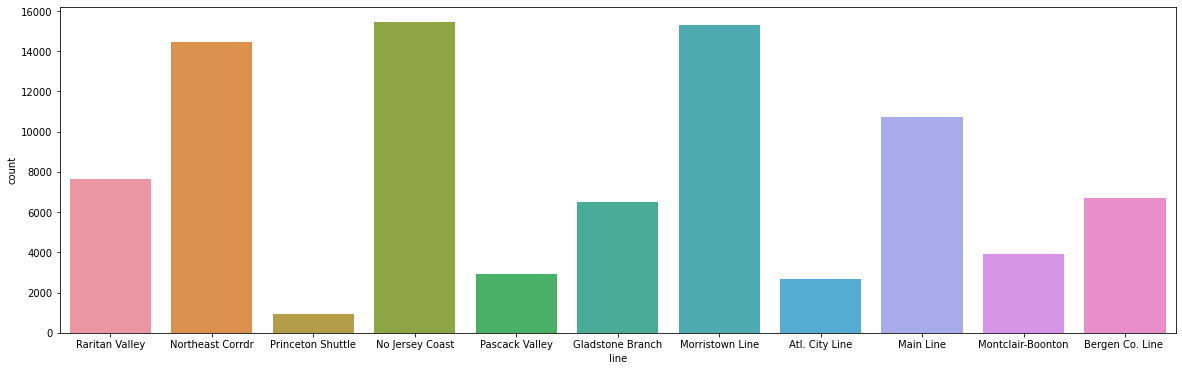

In [ ]:
# Countplot displaying train 'line' distribution with seaborn.
plt.figure(figsize=(20,6))
sns.countplot(x ='line', data = df)

The majority of train lines are coming from the North Jersey coast, the Morristown line, and the Northeastern Corridor train lines. We have the smallest amount of data for the Princeton Shuttle line. We will also one-hot encode these variables to feed into our machine model and determine any lines of interest.

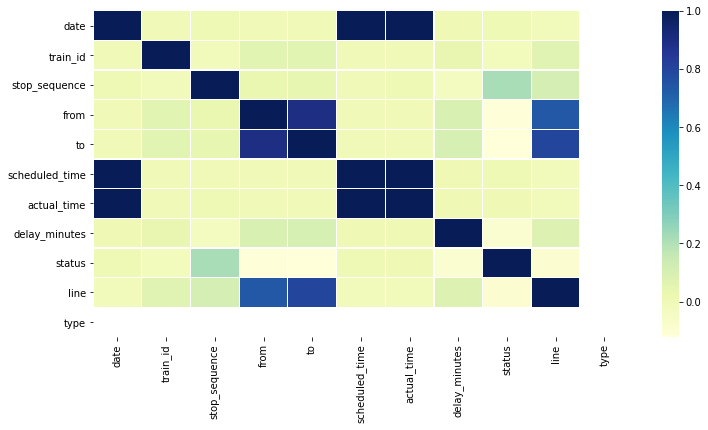

In [ ]:
# Defining figure size with pyplot.
plt.figure(figsize=(12, 6))
# Applying correlation scoring to dataframe.
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
# Creating heatmap with seaborn.
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

The strongest correlation being displayed is the correlation between train line and delay in minutes, as well as the correlation between to and from destinations and delay in minutes. 

In [ ]:
# Dropping the scheduled time and actual time columns since we are interested in the amount of delay which is measured in the delay feature having been already extracted for us.
df = df.drop(columns='scheduled_time')
df = df.drop(columns='actual_time')
df = df.drop(columns='date')

# We can drop our type feature as after dropping missing values it only contains one unique value and won't contribute to our DataFrame.
df = df.drop(columns='type')

In [ ]:
# Creating new column for our target variable that consists of booleans for 'delay_minutes' values greater than 15.
df['late'] = df['delay_minutes']>15

In [ ]:
# Dropping 'delay_minutes' column from DataFrame.
df = df.drop(columns='delay_minutes')

We can now drop our delay column as we have extracted the necessary info from it by creating a target variable derived from it.

# Supervised Learning with SelectKBest Feature Selection

In [ ]:
# Create our target variable y.
y = df['late']

# Create X values by dropping our target.
X = df.drop(columns=['late'])

# Use pandas get_dummies function to create dummy variables necessary for statistical interpretation (One Hot Encoding).
X = pd.get_dummies(X)

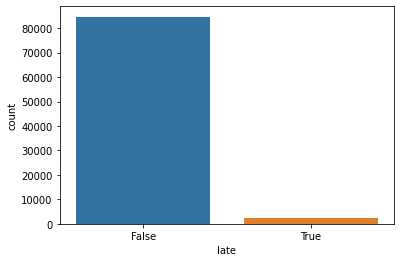

In [ ]:
# Creating a countplot for our target variable y with seaborn.
sns.countplot(y)

Examining the distribution of our target variable to see if our classes are balanced for best performance in supervised machine learning models.
The countplot shows that the target class is imbalanced, with our target value of delay greater than 15 minutes having as expected less True values. We must fix this with SMOTE (Synthetic Minority Oversampling Technique). SMOTE synthetically oversamples the minority target class to match when sampling strategy is set to minority.

In [ ]:
# Creating oversampler with minority sampling strategy.
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Fitting SMOTE to X and y variables.
X, y = sm.fit_resample(X, y)

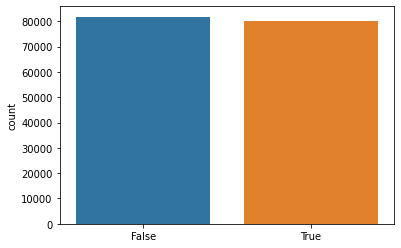

In [ ]:
# Creating another countplot for our target variable y with seaborn.
sns.countplot(y)

Re-examining y distribution to confirm classes have been balanced by SMOTE. Our distribution of True values now matches that of False values.

In [ ]:
# Putting X variable back into DataFrame after resampling for feature selection.
X = pd.DataFrame(X)

# Fitting SelectKBest feature selector to our variables using f_classif for our classification task with a k-value of 200.
selector = SelectKBest(f_classif, k=200).fit(X, y)

We will select the 200 best features based on highest k scores to reduce runtime and retain information. Reducing k-value to a number that is too low will cause overfitting due to loss of too much information. If we set a k value that is too high it will not reduce dimensionality therefore no impact on performance.

In [ ]:
# Creating boolean values by calling get_support on selector.
boolean = selector.get_support()

# Pulling newly selected columns into a new X variable with booleans.
X_new = X[X.columns[boolean]]

Our new X variable now consists of our 200 selected best features based on K values.

In [ ]:
# Checking shape property of original X variable.
X.shape

(162026, 790)

In [ ]:
# Checking shape property of new X variable.
X_new.shape

(162026, 200)

Examining newly selected feature set and confirming dimensionality reduction. We've successfully reduced our DataFrame by 590 columns, this will dramatically reduce run time.

In [ ]:
# Standardize features by removing the mean and scaling to unit variance with sklearns StandardScaler.
scaler = StandardScaler()

# Fit scaler to data by calling fit_transform on our new data.
scaled_data = scaler.fit_transform(X_new)

Scaling newly transformed features for machine learning model processing.

In [ ]:
# Using sklearns train_test_split to split data into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.20, random_state=42)

Now that we have finished processing, cleaning, and selecting our data features we are able to feed them into our supervised learning machine models and measure their performance.

## Logistic Regression Classifier with SelectKBest Selected Features

In [ ]:
# Timing our model.
start_time = time.time()

# Adjust our max iteration value for proper convergence.
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 54.542 seconds ---


Setting model run timer to print time upon completion, while adjusting the max iteration value for proper convergence. 

In [ ]:
# Print cross validation score.
cross_val_score(clf, X_train, y_train, cv=10)

array([0.87771949, 0.88281129, 0.87355346, 0.88103688, 0.88443141,
       0.88219411, 0.88196266, 0.88088258, 0.87903101, 0.88173121])

The cross validation score for the Logistic Regression Classifier is consistent and doesn't show any signs of over or underfitting.

In [ ]:
# Print classification report for our Logistic Regression classifier.
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.8802382274887367
Classification report:
              precision    recall  f1-score   support

       False       0.82      0.97      0.89     16239
        True       0.96      0.79      0.87     16167

    accuracy                           0.88     32406
   macro avg       0.89      0.88      0.88     32406
weighted avg       0.89      0.88      0.88     32406

Confusion matrix:
[[15773   466]
 [ 3415 12752]]


The classification report for our Logistic Regression classifier is showing consistent values and does not show signs of fitment issues. Logistic Regression classification performs best on binary outputs so it is not surprising this model works okay on our data. Performance has much room for improvement however.

## Gradient Boosting Classifier with SelectKbest Feature Selection

In [ ]:
# Timing our model.
start_time = time.time()

# Fitting gradient boosting classifier to training data. 
clf = GradientBoostingClassifier().fit(X_train, y_train)

# Print model run time.
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 105.426 seconds ---


In [ ]:
# Print cross validation score.
cross_val_score(clf, X_train, y_train, cv=5)

array([0.8840071 , 0.88632156, 0.89199198, 0.88759451, 0.8867073 ])

The cross validation score for the Gradient Boosting Classifier is consistent in the .88 range and doesn't show any signs of over or underfitting. This means our model should be expected to handle new data, since it is not overtraining on the training data. 

In [ ]:
# Print classification report for our Gradient Boosting classifier.
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.8844966981423193
Classification report:
              precision    recall  f1-score   support

       False       0.82      0.98      0.89     16239
        True       0.98      0.79      0.87     16167

    accuracy                           0.88     32406
   macro avg       0.90      0.88      0.88     32406
weighted avg       0.90      0.88      0.88     32406

Confusion matrix:
[[15930   309]
 [ 3434 12733]]


The classification report for our Gradient Boosting Classifier is also showing consistent values and does not show evidence of fitment issues. We are seeing slightly higher precision here than for our previous logistic regression model although at double the run time. Additional research could include hyperparameter tuning the learning rate and number of estimators to improve accuracy or run time since we did not include any hyperparameters.

## KNN Classifier with SelectKBest Feature Selection

In [ ]:
# Timing our model.
start_time = time.time()

# Creating KNN classifier with n_neighbors set to 25 to establish performance. 
knn = KNeighborsClassifier(n_neighbors=25)

# Fitting KNN classifier to training data. 
knn.fit(X_train, y_train)

print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 12.31 seconds ---


Model run time is much better than all previous models. n_neighbors hyperparameter was set to 25 as a base parameter, this may be tuned in further research to optimize KNN classification.

In [ ]:
# Print cross validation score for training variables.
cross_val_score(knn, X_train, y_train, cv=10)

array([0.92470298, 0.93141491, 0.92524302, 0.93048912, 0.93149205,
       0.92964049, 0.92863756, 0.93141491, 0.92894615, 0.93126061])

The cross validation score for the KNN Classifier is consistent and doesn't show any signs of over or underfitting.

In [ ]:
# Print classification report.
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.9277602913040794
Classification report:
              precision    recall  f1-score   support

       False       0.89      0.98      0.93     16239
        True       0.97      0.88      0.92     16167

    accuracy                           0.93     32406
   macro avg       0.93      0.93      0.93     32406
weighted avg       0.93      0.93      0.93     32406

Confusion matrix:
[[15836   403]
 [ 1938 14229]]


The classification report for our KNN Classifier is also showing consistent values and does not show evidence of fitment issues. Weighted averages are also higher as well as F1 score. We are seeing much better model performance here in all aspects than the previous gradient boosting and logistic regression models even without any hyperparameter tuning. KNN classification works well on dimensionally reduced data and runs fast as it does not require any prior training also known as lazy learning. Lazy learning is a machine learning method in which generalization of the training data is delayed until a query is made to the system, as opposed to eager learning, where the system tries to generalize the training data before receiving queries. This reduces the computational complexity needed to run the model.

## Decision Tree Classifier with SelectKBest Selected Features and Optimized Hyperparameters

In [ ]:
# Timing our model.
start_time = time.time()

# Building tree.
decision_tree = tree.DecisionTreeClassifier()

# Fit tree to training data.
decision_tree.fit(X_train, y_train)

# Print model run time.
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 4.881 seconds ---


We immediately see that decision tree model run time is much better than all previous models and half the time of our KNN classification model even without any hyperparameter tuning which we will perform in the followin cells. Binary decision trees are made through a process known as binary recursive partitioning. This is an iterative process of splitting the data into partitions, and then splitting it up further on each of the branches. This process also helps clean up unnecessary features and results in a fast and inexpensive model to run with performance equal to other classification techniques that require more compuational intensity.

In [ ]:
# Create tree parameter grid adjusting combination of criterion, max_depth, and max_features for best model performance.
tree_para = {'criterion':['gini','entropy'],
             'max_depth':[5,10,50,100,500],
             'max_features':[5,10,50,100,200]}
          
# Exhaustive search over specified parameter values using GridSearchCV. GridSearchCV will score all possible combinations of hyperparameters.
clf = GridSearchCV(decision_tree, tree_para, cv=5)

# Fit tree to training data using GridSearchCV.
clf.fit(X_train, y_train)

# Append GridSearchCV results to new DataFrame for easier interpretation.
gscv_df = pd.DataFrame(clf.cv_results_)

# Sort values by test score rank to find hyperparameters with the highest score.
gscv_df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
49,2.580922,0.115195,0.021123,0.000191,entropy,500,200,"{'criterion': 'entropy', 'max_depth': 500, 'ma...",0.954868,0.955910,0.958841,0.958070,0.958996,0.957337,0.001654,1
43,1.577682,0.313582,0.020883,0.000342,entropy,100,100,"{'criterion': 'entropy', 'max_depth': 100, 'ma...",0.955022,0.956025,0.958764,0.958031,0.958764,0.957321,0.001525,2
42,0.841726,0.109919,0.021190,0.000421,entropy,100,50,"{'criterion': 'entropy', 'max_depth': 100, 'ma...",0.954945,0.955871,0.958841,0.958070,0.958880,0.957321,0.001615,2
44,2.715991,0.168455,0.021238,0.000594,entropy,100,200,"{'criterion': 'entropy', 'max_depth': 100, 'ma...",0.954868,0.955871,0.958803,0.958070,0.958957,0.957314,0.001646,4
22,1.085163,0.318360,0.025233,0.003908,gini,500,50,"{'criterion': 'gini', 'max_depth': 500, 'max_f...",0.954907,0.955987,0.958880,0.957877,0.958726,0.957275,0.001569,5
19,2.409474,0.033035,0.021578,0.000687,gini,100,200,"{'criterion': 'gini', 'max_depth': 100, 'max_f...",0.954945,0.955832,0.958841,0.957915,0.958803,0.957267,0.001594,6
24,2.410687,0.018372,0.021431,0.000934,gini,500,200,"{'criterion': 'gini', 'max_depth': 500, 'max_f...",0.954907,0.955871,0.958803,0.957915,0.958803,0.957260,0.001591,7
18,1.354774,0.125200,0.020710,0.000241,gini,100,100,"{'criterion': 'gini', 'max_depth': 100, 'max_f...",0.955061,0.955832,0.958957,0.957761,0.958648,0.957252,0.001545,8
23,1.315217,0.218546,0.020964,0.000202,gini,500,100,"{'criterion': 'gini', 'max_depth': 500, 'max_f...",0.954907,0.955871,0.958880,0.957915,0.958648,0.957244,0.001578,9
14,2.439979,0.037467,0.021347,0.000994,gini,50,200,"{'criterion': 'gini', 'max_depth': 50, 'max_fe...",0.954868,0.955910,0.958841,0.957915,0.958687,0.957244,0.001582,9


Applying GridSearchCV to find optimal hyperparameters to improve our classification report. We are looking at a few parameters to see what works best with our model by implementing them into a parameter grid. More complex parameter grids require increased computation time. Finally we will be putting our results into a Pandas DataFrame for easier interpretation.

In [ ]:
# Start timing model.
start_time = time.time()

# Build decision tree using hyperparameters with the highest ranked test score.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=500,
    max_features=200,
)

# Fit tree to training data.
decision_tree.fit(X_train, y_train)

print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 4.388 seconds ---


We see a slight improvement in run time with optimized hyperparameters reducing run time by half a second.

In [ ]:
# Print cross validation score.
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.95448233, 0.95540812, 0.95317081, 0.95810832, 0.9618886 ,
       0.95656534, 0.9591884 , 0.95702824, 0.95772257, 0.95972844])

The cross validation score for the Decision Tree Classifier is consistent and doesn't show any signs of over or underfitting.

In [ ]:
# Print classificiation report. 
y_pred = decision_tree.predict(X_test)
dt_accuracy = accuracy_score(y_test,y_pred)
decision_tree_report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", dt_accuracy)
print("Classification report:")
print(decision_tree_report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.9563661050422761
Classification report:
              precision    recall  f1-score   support

       False       0.93      0.99      0.96     16239
        True       0.99      0.92      0.95     16167

    accuracy                           0.96     32406
   macro avg       0.96      0.96      0.96     32406
weighted avg       0.96      0.96      0.96     32406

Confusion matrix:
[[16133   106]
 [ 1308 14859]]


Model performance is much better than our previous models in all aspects with no signs of overfitting. We have reduced run time to 4.3 seconds and increased the accuracy score. Decision tree models are very fast and usually not computationally intensive as they do not compute all possibilities for a tree, and optimize which data to split in the given nodes. As the decision tree splits data further its speed increases also as it iterates over a smaller subset of data. 

## Random Forest Classifier with SelectKBest Selected Features and Optimized Hyperparameters

In [ ]:
# Timing our model.
start_time = time.time()

# Building random forest classifier.
rfc = ensemble.RandomForestClassifier()

# Fitting classifier to training data. 
rfc.fit(X_train, y_train)

# Print model runtime.
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 52.971 seconds ---


Setting up Random Forest Classifier by fitting to data and setting model run timer to print time upon completion. Model run time is much longer than the previous models. This is because random forest builds multiple decision trees and merges them together requiring more computational intensity than a single tree. We will try to reduce the run time with hyperparameter tuning below.

In [ ]:
# Creating hyperparameter grid.
param_grid = { 
    'n_estimators': [5,50,100,500,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8,10],
    'criterion' :['gini', 'entropy']
}

# Setting up GridSearchCV to run on our random forest classifier.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

# Fitting GridSearchCV to training data. 
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

We are looking at a few parameter combinations to see what works best with our model by implementing them into a parameter grid once again. More complex parameter grids require increased computation time.

In [ ]:
# Calling GridSearchCV .best_params_ to pull best parameters.
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 5}

This time we will find the best parameters by calling '.best_params_' instead of sorting by test rank score in a DataFrame. This will pull the best parameters from GridSearchCV also.

In [ ]:
# Timing our model.
start_time = time.time()

# Building random forest classifier with best parameters from GridSearchCV.
rfc = ensemble.RandomForestClassifier(criterion='entropy', 
                                      max_depth=10,
                                      max_features='auto',
                                      n_estimators=5, random_state=42)
# Fitting RFC with new hyperparameters.
rfc.fit(X_train, y_train)

# Print model run time.
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 1.315 seconds ---


Creating our model using optimized hyperparameters from GridSearchCV. We see a dramatic decrease in model run time from 50 seconds to just over 1 second.

In [ ]:
# Print cross-validation score.
cross_val_score(rfc, X_train, y_train, cv=10)

array([0.86205832, 0.85858664, 0.85334053, 0.86691869, 0.87756519,
       0.86853881, 0.86938744, 0.86583861, 0.86591575, 0.86066965])

Cross-validation score shows consistent scoring and no signs of overfitting or underfitting.

In [ ]:
# Print classification report.
y_pred = rfc.predict(X_test) 
rfc_accuracy = accuracy_score(y_test,y_pred)
rfc_report = classification_report(y_test, y_pred)
rfc_cm = confusion_matrix(y_test, y_pred)

print("Classification report:")
print("Accuracy: ", rfc_accuracy)
print(rfc_report)
print("Confusion matrix:")
print(rfc_cm)

Classification report:
Accuracy:  0.8704252298956984
              precision    recall  f1-score   support

       False       0.82      0.95      0.88     16239
        True       0.94      0.80      0.86     16167

    accuracy                           0.87     32406
   macro avg       0.88      0.87      0.87     32406
weighted avg       0.88      0.87      0.87     32406

Confusion matrix:
[[15353   886]
 [ 3313 12854]]


Model performance is not as good as the previous decision tree model in all aspects; precision, recall, f1-score, accuracy, and their respective averages. Once again no signs of overfitting or underfitting. We significantly decreased our run time with hyperparameter tuning using GridSearchCV to perform better than our Decision Tree Classifier however with a lower scoring.

As shown here ensemble models are not always better performers than their individual counterparts, they are better if the single decision tree models suffer from instability most usually.

### Supervised Learning with SelectKBest: Conclusion

In conclusion, decision tree model performance was best out of all other models (logistic regression, gradient boosting, KNN, random forest) using SelectKBest selected features with the best model run time and performance metrics. I hypothesize that this is due to our dimensionality reduction technique SelectKBest that allowed our decision tree to perform better than our random forest model. Without feature selection we most likely would have seen the opposite effect.

# Supervised Learning with PCA Feature Decomposition

In [ ]:
# Create our target variable y.
y = df['late']

# Create X values by dropping our target.
X = df.drop(columns=['late'])

# Use pandas get_dummies function to create dummy variables necessary for statistical interpretation (One Hot Encoding).
X = pd.get_dummies(X)

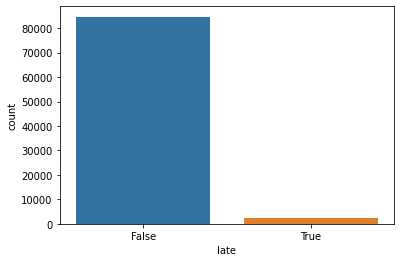

In [ ]:
# Creating a countplot for our target variable y with seaborn.
sns.countplot(y)

Examining initial target class to check balancing.

In [ ]:
# Creating oversampler with minority sampling strategy.
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Fitting SMOTE to X and y variables.
X, y = sm.fit_resample(X, y)

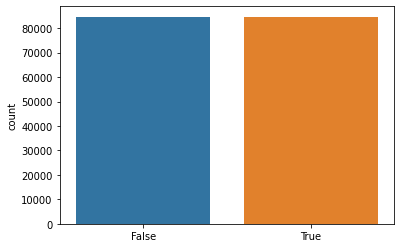

In [ ]:
# Creating another countplot for our target variable y with seaborn.
sns.countplot(y)

Class balancing using SMOTE and confirmation of class balance.

In [ ]:
# Standardize features by removing the mean and scaling to unit variance with sklearns StandardScaler.
scaler = StandardScaler()

# Fit scaler to data by calling fit_transform on our data.
scaled_data = scaler.fit_transform(X)

First we must scale our data so that it can be fit into our PCA model.

In [ ]:
# PCA feature reduction with the n_components set to represent 50% of the variance in our dataset.
sklearn_pca = PCA(n_components = 0.50)

# Apply PCA to our scaled data.
X_pca = sklearn_pca.fit_transform(scaled_data)

In [ ]:
# Checking shape property of original X variable.
X.shape

(169334, 790)

In [ ]:
# Checking shape property of new X variable.
X_pca.shape

(169334, 262)

Examing newly created PCA decomposed features. We successfully reduced DataFrame by 528 features to account for 50% of the variance in our original dataset.

In [ ]:
# Using sklearns train_test_split to split data into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.20, random_state=42)

## Logistic Regression Classifier with PCA

In [ ]:
# Timing our logistic regression classifier model.
start_time = time.time()

# Adjusting max iteration value for proper convergence.
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)

# Print model runtime.
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 11.219 seconds ---


In [ ]:
# Print the cross validation score.
cross_val_score(clf, X_train, y_train, cv=10)

array([0.89481066, 0.8954012 , 0.89473684, 0.8897911 , 0.88875766,
       0.89311287, 0.89333432, 0.89369556, 0.89812491, 0.8984202 ])

The cross validation score for the logistic regression classifier is showing consistent scoring and no signs of overfitting or underfitting.

In [ ]:
# Print classification report.
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.8957982697020699
Classification report:
              precision    recall  f1-score   support

       False       0.92      0.87      0.89     16804
        True       0.88      0.93      0.90     17063

    accuracy                           0.90     33867
   macro avg       0.90      0.90      0.90     33867
weighted avg       0.90      0.90      0.90     33867

Confusion matrix:
[[14549  2255]
 [ 1274 15789]]


The classification report for our logistic regression classifier shows no signs of overfitting. Recall for false values and precision for true values decreased performance compared to SelectKBest, but we are seeing performance improvement in the weighted averages of precision, recall, and f-1 score as well as a 1% improvement in accuracy score. Most remarkable is the runtime reduction from aroudn 50 seconds to around 10 seconds even though the number of dimensions actually increased with PCA feature decomposition (262 features for PCA versus 200 for SelectKBest).

## Gradient Boosting Classifier with PCA

In [ ]:
# Timing our model.
start_time = time.time()

# Fitting gradient boosting classifier to training data. 
clf = GradientBoostingClassifier().fit(X_train, y_train)

# Print model run time.
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 1082.101 seconds ---


Timing our gradient boosting classifier, we have a significantly longer run time than the logistic regression classifier as well as our gradient boosting classifier that we used with SelectKBest. This is due to the higher dimensionality of the PCA data so the gradient boosting classifier must form more trees during modeling.

In [ ]:
# Print cross validation score.
cross_val_score(clf, X_train, y_train, cv=5)

array([0.91795231, 0.91396619, 0.90982911, 0.9176171 , 0.91938877])

Cross validation score for Gradient Boosting Classifier is consistent and shows no signs of overfitting or underfitting.

In [ ]:
# Print classification report.
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.9157291758939381
Classification report:
              precision    recall  f1-score   support

       False       0.92      0.91      0.91     16804
        True       0.91      0.93      0.92     17063

    accuracy                           0.92     33867
   macro avg       0.92      0.92      0.92     33867
weighted avg       0.92      0.92      0.92     33867

Confusion matrix:
[[15209  1595]
 [ 1259 15804]]


We have slight performance increase of about .02 percent in weighted averages in all areas compared to logistic regression but at the cost of a much longer run time. The increased dimensionality of our PCA data also improved scoring in comparison to SelectKBest data but also increasing run time by almost 10x. The trade off in run time for a small performance increase seems to make this model an unlikely choice.

## KNN Classifier with PCA

In [ ]:
# Timing our model.
start_time = time.time()

# Creating KNN classifier with n_neighbors set to 25 to establish performance. 
knn = KNeighborsClassifier(n_neighbors=25)

# Fitting KNN classifier to training data. 
knn.fit(X_train, y_train)

# Print model runtime.
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 6.829 seconds ---


In [ ]:
# Print cross-validation score.
cross_val_score(knn, X_train, y_train, cv=10)

array([0.95570975, 0.95393814, 0.95467631, 0.95600502, 0.95475013,
       0.95342142, 0.9550454 , 0.95851174, 0.95533737, 0.9551159 ])

Cross validation score is consistent and shows no signs of fitment issues.

In [ ]:
# Printing classification report with test variables and prediction.
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.9585141878524818
Classification report:
              precision    recall  f1-score   support

       False       0.93      0.99      0.96     16804
        True       0.99      0.93      0.96     17063

    accuracy                           0.96     33867
   macro avg       0.96      0.96      0.96     33867
weighted avg       0.96      0.96      0.96     33867

Confusion matrix:
[[16597   207]
 [ 1198 15865]]


Classification report for KNN Classifier is much better than our previous models with a higher weighted average in all categories. KNN was able to process PCA reduced data in a faster time and with better scoring than SelectKBest selected features despite having a higher dimensionality.

## Decision Tree Classifier with PCA Decomposed Features and Optimized Hyperparameters

In [ ]:
# Timing our model.
start_time = time.time()

# Building tree.
decision_tree = tree.DecisionTreeClassifier()

# Fit tree to training data.
decision_tree.fit(X_train, y_train)

# Print model run time.
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 55.319 seconds ---


Timing and training our initial tree before running GridSearchCV. We have a signficant increase in run time compared to our decision tree classifier with SelectKBest selected features due to increased dimensionality.

In [ ]:
# Create parameter grid for GridSearchCV.
tree_para = {'criterion':['gini','entropy'],
             'max_depth':[10,100,500,1000],
             'max_features':[10,50,100,200]}

# Create decision tree classifier with GridSearchCV.
clf = GridSearchCV(decision_tree, tree_para, cv=5)

# Fitting decision tree classifier to training data.
clf.fit(X_train, y_train)

# Putting GridSearchCV results into Pandas DataFrame.
gscv_df = pd.DataFrame(clf.cv_results_)

# Sorting DataFrame by highest ranked test score.
gscv_df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,34.193662,1.844237,0.026496,0.001758,gini,500,200,"{'criterion': 'gini', 'max_depth': 500, 'max_f...",0.981989,0.982358,0.982062,0.983095,0.982025,0.982306,0.000416,1
22,15.050028,1.337050,0.024560,0.000567,entropy,100,100,"{'criterion': 'entropy', 'max_depth': 100, 'ma...",0.981583,0.982505,0.982099,0.981213,0.982689,0.982018,0.000554,2
31,29.650594,2.007559,0.024321,0.001075,entropy,1000,200,"{'criterion': 'entropy', 'max_depth': 1000, 'm...",0.980881,0.983244,0.981213,0.982468,0.982173,0.981996,0.000856,3
7,35.089800,1.749943,0.026564,0.001337,gini,100,200,"{'criterion': 'gini', 'max_depth': 100, 'max_f...",0.981361,0.982247,0.981951,0.982025,0.982283,0.981973,0.000331,4
21,7.392730,0.517641,0.024046,0.000093,entropy,100,50,"{'criterion': 'entropy', 'max_depth': 100, 'ma...",0.980808,0.983207,0.981951,0.981914,0.981656,0.981907,0.000770,5
26,14.677475,1.396635,0.024701,0.000737,entropy,500,100,"{'criterion': 'entropy', 'max_depth': 500, 'ma...",0.981066,0.981841,0.982320,0.981951,0.982283,0.981892,0.000453,6
6,16.716604,1.133720,0.025918,0.000849,gini,100,100,"{'criterion': 'gini', 'max_depth': 100, 'max_f...",0.981287,0.982432,0.981028,0.981877,0.982394,0.981804,0.000568,7
10,16.899153,1.264238,0.025741,0.001070,gini,500,100,"{'criterion': 'gini', 'max_depth': 500, 'max_f...",0.981066,0.982911,0.981324,0.982025,0.981693,0.981804,0.000642,8
23,31.335277,1.510281,0.024843,0.001246,entropy,100,200,"{'criterion': 'entropy', 'max_depth': 100, 'ma...",0.980660,0.982321,0.981619,0.982283,0.981803,0.981737,0.000603,9
14,15.425827,1.193874,0.025649,0.001306,gini,1000,100,"{'criterion': 'gini', 'max_depth': 1000, 'max_...",0.980844,0.982284,0.982062,0.981988,0.981360,0.981708,0.000529,10


The best performance was seen using the hyperparameters criterion: gini, max_depth: 500, and max_features: 200. We will use these hyperparameters to train our next decision tree model.

In [ ]:
# Timing our model.
start_time = time.time()

# Creating decision tree using new hyperparameters.
decision_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    max_depth=500,
    max_features=200,
)

# Fitting tree to training data.
decision_tree.fit(X_train, y_train)

# Print model runtime.
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 44.305 seconds ---


Timing and training our tree using best parameters from GridSearchCV, we were able to decrease the model run time by over 10 seconds. 

In [ ]:
# Print cross validation score.
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.97984794, 0.98043847, 0.97984794, 0.98206245, 0.98302207,
       0.97874068, 0.98088138, 0.9819873 , 0.97999409, 0.98117525])

Our decision tree is showing consistent scoring with no signs of underfitting or overfitting.

In [ ]:
# Print classification report.
y_pred = decision_tree.predict(X_test)
dt_accuracy = accuracy_score(y_test,y_pred)
decision_tree_report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", dt_accuracy)
print("Classification report:")
print(decision_tree_report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.9824312752827236
Classification report:
              precision    recall  f1-score   support

       False       0.98      0.99      0.98     16804
        True       0.99      0.98      0.98     17063

    accuracy                           0.98     33867
   macro avg       0.98      0.98      0.98     33867
weighted avg       0.98      0.98      0.98     33867

Confusion matrix:
[[16627   177]
 [  418 16645]]


This decision tree model with PCA decomposed features is performing better now with a lower run time. However, in comparison to our decision tree classifier using SelectKBest features, model run time is about 10x longer. Accuracy score has only improved from .956 with SelectKBest to .982 with PCA decomposed features. So the decision tree has a trade off between processing time, dimensionality, and accuracy that must be established for each use case. It seems hard to justify the increase in run time for the small benefit of slight increase in accuracy scoring seen here.


## Random Forest Classifier with GridSearchCV and PCA

In [ ]:
# Timing our model.
start_time = time.time()

# Building random forest classifier.
rfc = ensemble.RandomForestClassifier()

# Fitting classifier to training data. 
rfc.fit(X_train, y_train)

# Print model runtime.
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 176.782 seconds ---


Creating and timing our initial model before processing with GridSearchCV to find the best hyperparameters.

In [ ]:
# Creating hyperparameter grid.
param_grid = { 
    'n_estimators': [5,50,100,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
}

# Setting up GridSearchCV to run on our random forest classifier.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)

# Fitting GridSearchCV to training data. 
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
# Calling .best_params_ to pull best parameters from GridSearchCV.
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [ ]:
# Timing our model.
start_time = time.time()

# Building random forest classifier with best parameters from GridSearchCV.
rfc = ensemble.RandomForestClassifier(criterion='gini', 
                                      max_depth=8,
                                      max_features='sqrt',
                                      n_estimators=100, random_state=42)

# Fitting RFC with new hyperparameters.
rfc.fit(X_train, y_train)

# Printing model runtime.
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 101.192 seconds ---


Using optimized hyperparameters from GridSearchCV we were able to reduce run time by about 40%. 

In [ ]:
# Print cross-validation score.
cross_val_score(rfc, X_train, y_train, cv=10)

array([0.93659113, 0.93326936, 0.93253119, 0.93481952, 0.92810216,
       0.92441131, 0.9347457 , 0.93223092, 0.93230474, 0.93466706])

Cross-validation score is consistent and does not show any signs of overfitting or underfitting.

In [ ]:
# Print classification report.
y_pred = rfc.predict(X_test) 
rfc_accuracy = accuracy_score(y_test,y_pred)
rfc_report = classification_report(y_test, y_pred)
rfc_cm = confusion_matrix(y_test, y_pred)

print("Classification report:")
print("Accuracy: ", rfc_accuracy)
print(rfc_report)
print("Confusion matrix:")
print(rfc_cm)

Classification report:
Accuracy:  0.9316443735790002
              precision    recall  f1-score   support

       False       0.92      0.94      0.93     16804
        True       0.94      0.92      0.93     17063

    accuracy                           0.93     33867
   macro avg       0.93      0.93      0.93     33867
weighted avg       0.93      0.93      0.93     33867

Confusion matrix:
[[15840   964]
 [ 1351 15712]]


The previous decision tree model with PCA decomposed features is performing better than the random forest model here in terms of both runtime and scoring. Random forest run time is longer with a reduction in accuracy score and weighted averages for precision, recall, and f1-score.  As shown again here ensemble models are not always better performers than their individual counterparts, they are better if the single decision tree models suffer from instability most usually.

In conclusion, our KNN classifier worked best using PCA feature reduced data with the best combination of run time and performance. Decision tree performed best in terms of scoring but at the cost of a long run time.

# Unsupervised Learning

We will use KMeans and DBSCAN clustering techniques on our data using PCA and t-SNE feature reduced data to see which combination of dimensionality reduction and clustering techniques works best for this dataset.

## PCA Feature Decomposition

In [ ]:
# Import initial DataFrame again for unsupervised learning.
df = pd.read_csv('/content/drive/My Drive/Data/2020_05.csv')

In [ ]:
# Dropping redundant columns 'to_id' and 'from_id' from DataFrame.
df = df.drop(columns='to_id')
df = df.drop(columns='from_id')

Dropping redundant features such as to_id and from_id since our actual locations are listed in features to and from and can be used as dummy variables.

In [ ]:
# Dropping missing values from DataFrame.
df = df.dropna()

In [ ]:
# Drop redundant columns once again from DataFrame.
df = df.drop(columns='scheduled_time')
df = df.drop(columns='actual_time')
df = df.drop(columns='date')

Dropping the scheduled time and actual time columns since we are only interested in the amount of delay which is measured and already extracted from these columns for us in the 'delay_minutes' feature. The date feature is also not important to our clustering model.

In [ ]:
# Dropping 'type' column, contains only one value.
df = df.drop(columns='type')

We can drop our type feature as after dropping missing values it only contains one unique value and won't contribute to our data.

In [ ]:
# Creating a new feature to indicate if a train is late or not, we will use a threshold of 15 minute delay time.
df['late'] = df['delay_minutes']>15

# We can now drop our delay column as we have extracted the necessary info from it.
df = df.drop(columns='delay_minutes')

# One-hot encoding statistical variables for machine learning.
df = pd.get_dummies(df, columns={'from','to','line','train_id','status','late'})

Before Principle Component Analysis, we must scale our features to bring the mean to zero and the standard deviation to 1.

In [ ]:
# Standardize features by removing the mean and scaling to unit variance with sklearns StandardScaler.
scaler = StandardScaler()

# Fit scaler to data by calling fit_transform on our data.
X_scale = scaler.fit_transform(df)

# Storing scaled data into new DataFrame.
df_scale = pd.DataFrame(X_scale, columns=df.columns)
df_scale.head()

,stop_sequence,status_cancelled,status_departed,status_estimated,train_id_0069,train_id_0070,train_id_0071,train_id_0072,train_id_0073,train_id_0074,train_id_0075,train_id_0076,train_id_0077,train_id_0078,train_id_0079,train_id_0080,train_id_0081,train_id_0082,train_id_0093,train_id_0094,train_id_0509,train_id_0510,train_id_0513,train_id_0514,train_id_0515,train_id_0518,train_id_0519,train_id_0522,train_id_0523,train_id_0526,train_id_0527,train_id_0530,train_id_0531,train_id_0534,train_id_0535,train_id_0538,train_id_0539,train_id_0544,train_id_0545,train_id_0710,...,to_Radburn Fair Lawn,to_Rahway,to_Ramsey Main St,to_Ramsey Route 17,to_Raritan,to_Red Bank,to_Ridgewood,to_River Edge,to_Roselle Park,to_Rutherford,to_Salisbury Mills-Cornwall,to_Secaucus Lower Lvl,to_Secaucus Upper Lvl,to_Short Hills,to_Sloatsburg,to_Somerville,to_South Amboy,to_South Orange,to_Spring Lake,to_Spring Valley,to_Stirling,to_Suffern,to_Summit,to_Teterboro,to_Towaco,to_Trenton,to_Tuxedo,to_Union,to_Upper Montclair,to_Waldwick,to_Walnut Street,to_Watchung Avenue,to_Watsessing Avenue,to_Wayne-Route 23,to_Wesmont,to_Westfield,to_Westwood,to_Wood Ridge,to_Woodbridge,to_Woodcliff Lake
0,-1.413841,-0.171334,0.366247,-0.314012,-0.04984,-0.072035,-0.048432,-0.04984,-0.04984,-0.072035,-0.064126,-0.072035,-0.05188,-0.064396,-0.05188,-0.04984,-0.067553,-0.072035,-0.038943,-0.038943,-0.023472,-0.033889,-0.032856,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.032856,-0.017925,-0.032856,-0.033889,-0.032856,-0.033889,-0.033889,-0.024897,-0.032856,-0.042341,...,-0.074332,-0.129739,-0.085116,-0.086406,-0.081913,-0.088008,-0.112422,-0.043811,-0.081913,-0.074332,-0.05522,-0.126314,-0.174571,-0.101332,-0.05522,-0.081913,-0.088008,-0.101332,-0.064844,-0.048313,-0.073627,-0.092529,-0.123424,-0.01946,-0.028145,-0.114394,-0.05522,-0.081913,-0.038497,-0.108648,-0.038497,-0.038497,-0.062943,-0.028145,-0.070078,-0.081913,-0.043811,-0.043811,-0.088008,-0.01946
1,-1.213208,-0.171334,0.366247,-0.314012,-0.04984,-0.072035,-0.048432,-0.04984,-0.04984,-0.072035,-0.064126,-0.072035,-0.05188,-0.064396,-0.05188,-0.04984,-0.067553,-0.072035,-0.038943,-0.038943,-0.023472,-0.033889,-0.032856,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.032856,-0.017925,-0.032856,-0.033889,-0.032856,-0.033889,-0.033889,-0.024897,-0.032856,-0.042341,...,-0.074332,-0.129739,-0.085116,-0.086406,-0.081913,-0.088008,-0.112422,-0.043811,-0.081913,-0.074332,-0.05522,-0.126314,-0.174571,-0.101332,-0.05522,-0.081913,-0.088008,-0.101332,-0.064844,-0.048313,-0.073627,-0.092529,-0.123424,-0.01946,-0.028145,-0.114394,-0.05522,12.208107,-0.038497,-0.108648,-0.038497,-0.038497,-0.062943,-0.028145,-0.070078,-0.081913,-0.043811,-0.043811,-0.088008,-0.01946
2,-1.012575,-0.171334,0.366247,-0.314012,-0.04984,-0.072035,-0.048432,-0.04984,-0.04984,-0.072035,-0.064126,-0.072035,-0.05188,-0.064396,-0.05188,-0.04984,-0.067553,-0.072035,-0.038943,-0.038943,-0.023472,-0.033889,-0.032856,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.032856,-0.017925,-0.032856,-0.033889,-0.032856,-0.033889,-0.033889,-0.024897,-0.032856,-0.042341,...,-0.074332,-0.129739,-0.085116,-0.086406,-0.081913,-0.088008,-0.112422,-0.043811,12.208107,-0.074332,-0.05522,-0.126314,-0.174571,-0.101332,-0.05522,-0.081913,-0.088008,-0.101332,-0.064844,-0.048313,-0.073627,-0.092529,-0.123424,-0.01946,-0.028145,-0.114394,-0.05522,-0.081913,-0.038497,-0.108648,-0.038497,-0.038497,-0.062943,-0.028145,-0.070078,-0.081913,-0.043811,-0.043811,-0.088008,-0.01946
3,-0.811942,-0.171334,0.366247,-0.314012,-0.04984,-0.072035,-0.048432,-0.04984,-0.04984,-0.072035,-0.064126,-0.072035,-0.05188,-0.064396,-0.05188,-0.04984,-0.067553,-0.072035,-0.038943,-0.038943,-0.023472,-0.033889,-0.032856,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.032856,-0.017925,-0.032856,-0.033889,-0.032856,-0.033889,-0.033889,-0.024897,-0.032856,-0.042341,...,-0.074332,-0.129739,-0.085116,-0.086406,-0.081

In [ ]:
# PCA with the number of components set to 2, this will reduce our data to two dimensions.
pca = PCA(n_components=2)

# We get the components by calling fit_transform method with our data.
pca_components = pca.fit_transform(df_scale)

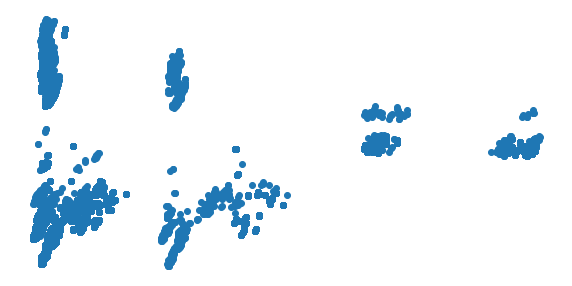

In [ ]:
# Defining pyplot figure size.
plt.figure(figsize=(10,5))

# Creating scatterplot of pca component dimensions with pyplot.
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

This scatterplot shows what our data looks like now reduced to two dimensions, KMeans and DBSCAN will label these clusters according to their respective algorithms and we will test the performance of each using the silhouette score metric.

## Applying KMeans to PCA

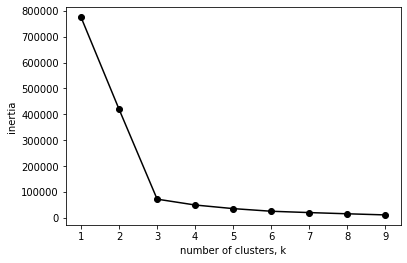

In [ ]:
# Components are now in Pandas DataFrame.
PCA_components = pd.DataFrame(pca_components)
# Create range of k values.
ks = range(1, 10)
inertias = []
for k in ks:
    # Create KMeans instance with k clusters: model.
    model = KMeans(n_clusters=k)

    # Fit model to samples.
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias.
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

The elbow method uses the K value plotted on the x-axis and the inertia plotted on the y-axis to choose where the plot comes to a point or 'elbow'. This visual method may give us an area to focus on but it is wise to go ahead and score all clusters up to 10 statistically. The elbow method here would give us a KMeans cluster value of 3.

In [ ]:
# Defining KMeans cluster number of 2 and labeling PCA components.
labels = KMeans(n_clusters=2, random_state=123).fit_predict(PCA_components)
# Print silhouette score of KMeans.
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.772414991935028


In [ ]:
labels = KMeans(n_clusters=3, random_state=123).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.8063733239297769


Elbow method score, let's see if this score remains the highest.

In [ ]:
labels = KMeans(n_clusters=4, random_state=123).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.8067473544042935


The silhouette score seen here is very close to our elbow value for KMeans of 3 but still an improvement. If we only relied on visual methods we may have chose a KMeans value that did not perform as well.

In [ ]:
labels = KMeans(n_clusters=5, random_state=123).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.7264040259225821


In [ ]:
labels = KMeans(n_clusters=6, random_state=123).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.7160201994421462


In [ ]:
labels = KMeans(n_clusters=7, random_state=123).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.6538114465224562


In [ ]:
labels = KMeans(n_clusters=8, random_state=123).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.6571489801054592


In [ ]:
labels = KMeans(n_clusters=9, random_state=123).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.5169613151354236


In [ ]:
labels = KMeans(n_clusters=10, random_state=123).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.5520295356344731


In [ ]:
# Defining the k-means with the best silhouette value (4) and timing it.
kmeans_cluster = KMeans(n_clusters=4, random_state=123)
# Fitting and timing clustering.
%timeit kmeans_cluster.fit(PCA_components)
y_pred = kmeans_cluster.predict(PCA_components)

1 loop, best of 3: 521 ms per loop


Timing and building the best performing model with a KMeans value of 4 and a silhouette score of .8. A perfect silhouette score would be a value of 1. 

## Cluster Analysis of KMeans Clusters using PCA

In [ ]:
# Creating a copy of our original dataframe before dummy variable creation and mapping our KMeans clusters onto it.
df2 = pd.read_csv('/content/drive/My Drive/Data/2020_05.csv')

# Dropping redundant features such as to_id and from_id since our actual locations are listed in features to and from and can be used as dummy variables.
df2 = df2.drop(columns='to_id')
df2 = df2.drop(columns='from_id')

# Dropping missing values.
df2 = df2.dropna()

# Dropping the scheduled time and actual time columns since we are only interested in the amount of delay which is measured for us in the delay feature.
df2 = df2.drop(columns='scheduled_time')
df2 = df2.drop(columns='actual_time')
df2 = df2.drop(columns='date')

# We can drop our type feature as after dropping missing values it only contains one unique value and won't contribute to our data.
df2 = df2.drop(columns='type')

# Creating feature to indicate if a train is late or not, we will use a threshold of 15 minutes.
df2['late'] = df2['delay_minutes']>15

# We can now drop our delay column as we have extracted the necessary info from it.
df2 = df2.drop(columns='delay_minutes')

Now that we have recreated our DataFrame before processing we can create a feature to label the data to its respective cluster.

In [ ]:
# Finally, attach the cluster labels from KMeans to the original DataFrame.
df2['cluster_label'] = kmeans_cluster.labels_

In [ ]:
# Examining DataFrame to confirm cluster labels have been attached.
df2.head()

,train_id,stop_sequence,from,to,status,line,late,cluster_label
0,5543,1.0,Newark Penn Station,Newark Penn Station,departed,Raritan Valley,False,1
1,5543,2.0,Newark Penn Station,Union,departed,Raritan Valley,False,1
2,5543,3.0,Union,Roselle Park,departed,Raritan Valley,False,1
3,5543,4.0,Roselle Park,Cranford,departed,Raritan Valley,False,1
4,5543,5.0,Cranford,Westfield,departed,Raritan Valley,False,1


In [ ]:
# Creating boolean values to create new cluster DataFrames.
clusters1 = df2['cluster_label'] == 0
clusters2 = df2['cluster_label'] == 1
clusters3 = df2['cluster_label'] == 2
clusters4 = df2['cluster_label'] == 3

In [ ]:
# Applying boolean against dataframe to pull correct rows.
clusters1df = df2[clusters1]
clusters2df = df2[clusters2]
clusters3df = df2[clusters3]
clusters4df = df2[clusters4]

Now that we have labeled our data with the correct cluster and put the clusters into an individual DataFrame, we can analyze and plot each cluster by analyzing the cluster DataFrames.

### First Cluster Analysis

In [ ]:
# Examining cluster size.
clusters1df.shape

(45446, 8)

The first cluster is the largest in comparison to the other four clusters with our PCA data using KMeans clustering. 

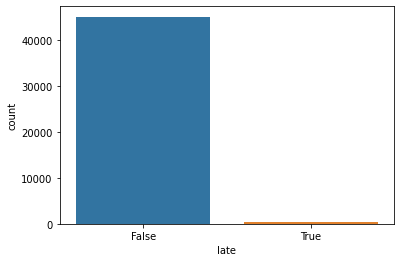

In [ ]:
# Creating countplot with seaborn and defining figure size.
plt.figure(figsize=(6,4))
sns.countplot(clusters1df['late'])

This cluster is comprised of mostly unlate trains with some late trains slipping through as shown here on the countplot for our late variable.

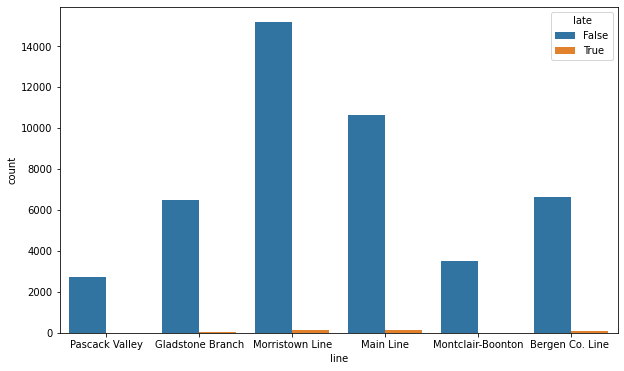

In [ ]:
# Defining figure size.
plt.figure(figsize=(10,6))
# Creating countplot of train lines for analysis using seaborn.
sns.countplot(clusters1df['line'], hue=clusters1df['late'])

This cluster seems to be representative of mostly unlate trains from various lines. We see some late values for some train lines in here but with counts significantly less than unlate trains. 

### Second Cluster Analysis

In [ ]:
# Examining cluster size.
clusters2df.shape

(38477, 8)

This is the second largest cluster in size compared to other four clusters.

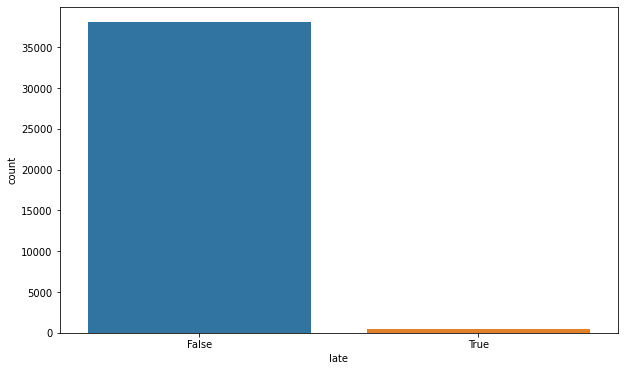

In [ ]:
# Creating countplot of our late variable with seaborn and defining figure size.
plt.figure(figsize=(10,6))
sns.countplot(clusters2df['late'])

This second cluster is also comprised of mostly unlate trains with a few late values slipping in like before in the first cluster. This is not surprising considering the size of this cluster as it is almost half the dataset like the first.

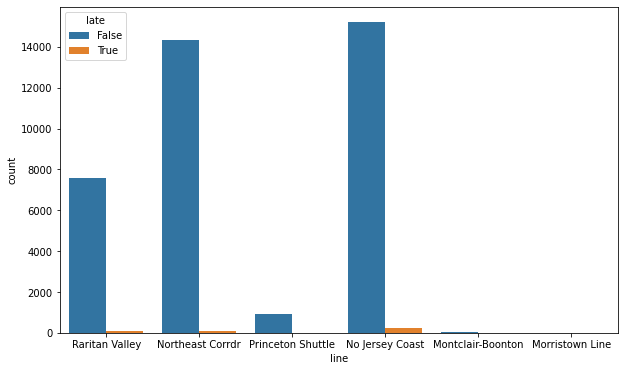

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(clusters2df['line'], hue=clusters2df['late'])

This cluster is comprised mostly of different train lines than the first. We have some very small amounts of some train lines from the first cluster like the Morristown line. 

### Third Cluster Analysis

In [ ]:
# Examining cluster size.
clusters3df.shape

(1124, 8)

This cluster size is much smaller than our first two clusters with only 1,124 values.

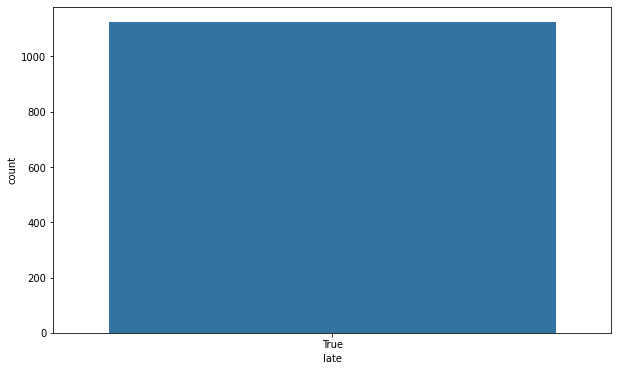

In [ ]:
# Creating countplot of our late variable with seaborn and defining figure size.
plt.figure(figsize=(10,6))
sns.countplot(clusters3df['late'])

Unlike the first two clusters also this cluster is entirely comprised of late trains with no false values.

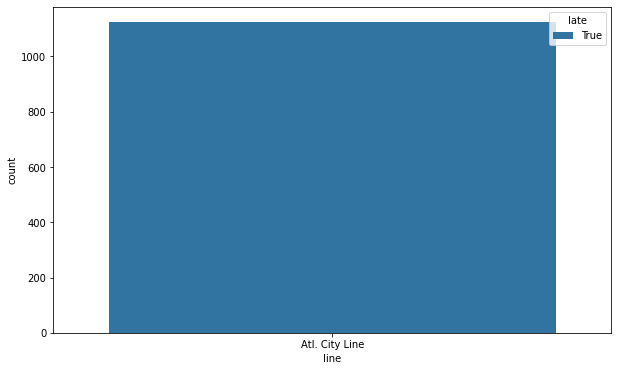

In [ ]:
plt.figure(figsize=(10,6))
# Creating countplot of train lines for analysis using seaborn.
sns.countplot(clusters3df['line'], hue=clusters3df['late'])

Clustering algorith grouped only trains from one line into this cluster interestingly. This suggests the Atlantic City Line is in need of upgrades.

### Fourth Cluster Analysis

In [ ]:
# Examining cluster size.
clusters4df.shape

(2125, 8)

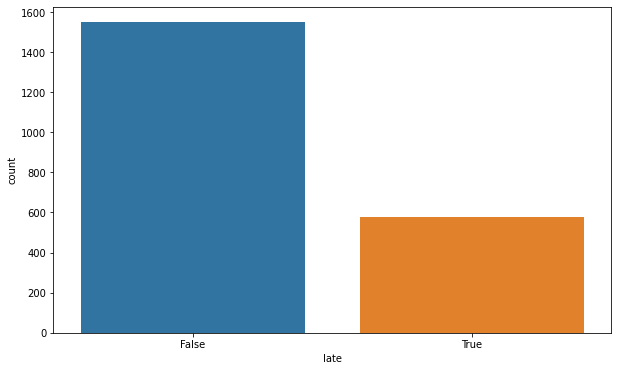

In [ ]:
# Creating countplot of our late variable with seaborn and defining figure size.
plt.figure(figsize=(10,6))
sns.countplot(clusters4df['late'])

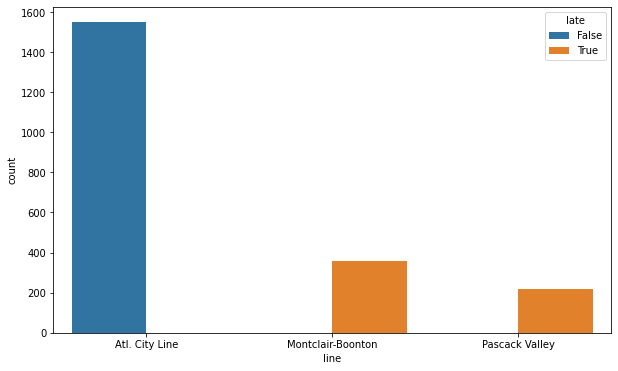

In [ ]:
plt.figure(figsize=(10,6))
# Creating countplot of train lines for analysis using seaborn.
sns.countplot(clusters4df['line'], hue=clusters4df['late'])

It seems that the Montclair-Boonton and Pascack Valley lines are in need of upgrades also. Our clustering algorithm was able to group these lines from the other clusters.

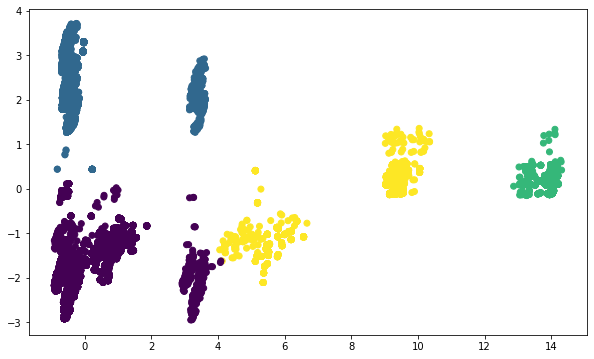

In [ ]:
# Finally, let's visualize the clusters formed by KMeans and PCA with a simple scatterplot.
plt.figure(figsize=(10,6))
plt.scatter(PCA_components[0],PCA_components[1], c=y_pred); 
plt.show()

## Applying DBSCAN Clustering to PCA

In [ ]:
dbscan_cluster = DBSCAN(eps=.2, min_samples=150)
labels = dbscan_cluster.fit_predict(pca_components)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(pca_components, labels, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.47302328020569545


Defining the density based algorithm DBSCAN and adjusting the epsilon and minimum sample values. The silhouette score may be improved upon with different hyperparameter values.

In [ ]:
dbscan_cluster = DBSCAN(eps=.1, min_samples=150)
labels = dbscan_cluster.fit_predict(pca_components)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(pca_components, labels, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.4842396648991047


Reducing the epsilon value seems to have made our model perform slightly better, let's try increasing the minimum sample value instead.

In [ ]:
dbscan_cluster = DBSCAN(eps=.2, min_samples=200)
labels = dbscan_cluster.fit_predict(pca_components)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(pca_components, labels, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.4720658550038806


Slight improvement on score with increased minimum sample value and using the initial epsilon value. Let's try to increase the epsilon value further.

In [ ]:
dbscan_cluster = DBSCAN(eps=.3, min_samples=200)
labels = dbscan_cluster.fit_predict(pca_components)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(pca_components, labels, metric='euclidean')))

Setting the EPS at .3 causes our kernel to crash with a large minimum sample value, so we will try further adjusting our minimum sample value.

In [ ]:
dbscan_cluster = DBSCAN(eps=.1, min_samples=250)
labels = dbscan_cluster.fit_predict(pca_components)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(pca_components, labels, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.4483957169309533


Increased minimum sample size caused reduced performance for DBSCAN clustering here. Let's try a smaller sample size.

In [ ]:
dbscan_cluster = DBSCAN(eps=.1, min_samples=25)
labels = dbscan_cluster.fit_predict(pca_components)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(pca_components, labels, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.3366514737362271


In [ ]:
dbscan_cluster = DBSCAN(eps=.1, min_samples=100)
labels = dbscan_cluster.fit_predict(pca_components)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(pca_components, labels, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.5147450422934078


In [ ]:
dbscan_cluster = DBSCAN(eps=.2, min_samples=100)
labels = dbscan_cluster.fit_predict(pca_components)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(pca_components, labels, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.5942209751723609


In [ ]:
dbscan_cluster = DBSCAN(eps=.3, min_samples=125)
labels = dbscan_cluster.fit_predict(pca_components)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(pca_components, labels, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.6529191706890024


Hyperparameter tuning was able to increase model performance significantly adjusting minimum sample value and finally settling on a value of 125 and epsilon value of .3. Although silhouette score performance is not better than KMeans it may still provide meaningful clustering so we will analyze the clusters below.

## DBSCAN Cluster Analysis with PCA Dimensionality Reduction

In [ ]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

Let's see how many clusters our DBSCAN algorithm was able to identify by calling unique values for labeled clustering, we have 9 clusters. The -1 value is where DBSCAN grouped outliers.

In [ ]:
df2['dbscan_pca_cluster_label'] = labels

Attaching DBSCAN cluster labels to original dataframe.

In [ ]:
cluster1 = df2['dbscan_pca_cluster_label'] == 0
cluster2 = df2['dbscan_pca_cluster_label'] == 1
cluster3 = df2['dbscan_pca_cluster_label'] == 2
cluster4 = df2['dbscan_pca_cluster_label'] == 3
cluster5 = df2['dbscan_pca_cluster_label'] == 4
cluster6 = df2['dbscan_pca_cluster_label'] == 5
cluster7 = df2['dbscan_pca_cluster_label'] == 6
cluster8 = df2['dbscan_pca_cluster_label'] == 7
cluster9 = df2['dbscan_pca_cluster_label'] == 8
outliercluster = df2['dbscan_pca_cluster_label'] == -1

Creating boolean values to create new cluster dataframes.

In [ ]:
cluster1df = df2[cluster1]
cluster2df = df2[cluster2]
cluster3df = df2[cluster3]
cluster4df = df2[cluster4]
cluster5df = df2[cluster5]
cluster6df = df2[cluster6]
cluster7df = df2[cluster7]
cluster8df = df2[cluster8]
cluster9df = df2[cluster9]
outlierclusterdf = df2[outliercluster]

Applying boolean against dataframe to pull correct rows.

### First Cluster Analysis

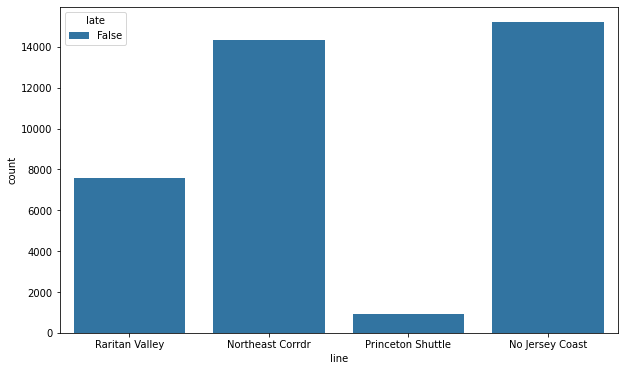

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(cluster1df['line'], hue=cluster1df['late'])

### Second Cluster Analysis

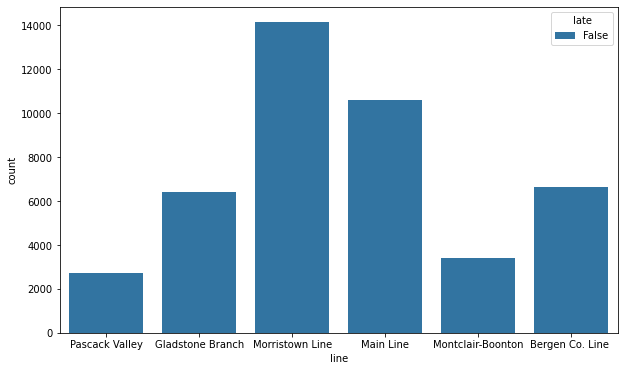

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(cluster2df['line'], hue=cluster2df['late'])

### Third Cluster Analysis

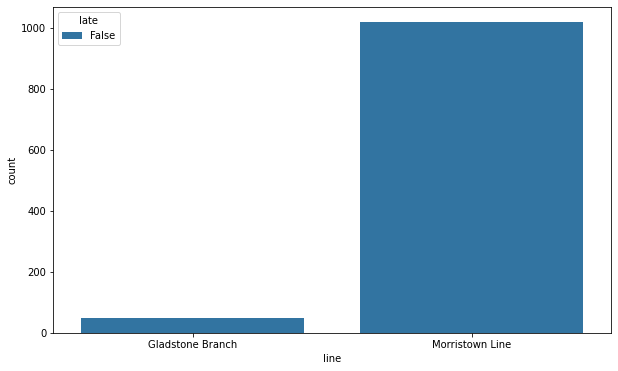

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(cluster3df['line'], hue=cluster3df['late'])

### Fourth Cluster Analysis

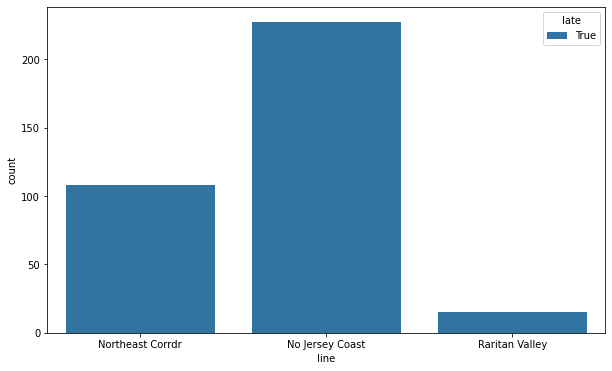

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(cluster4df['line'], hue=cluster4df['late'])

DBSCAN clustering algorithm was able to correctly group only late trains into the fourth cluster.

### Fifth Cluster Analysis

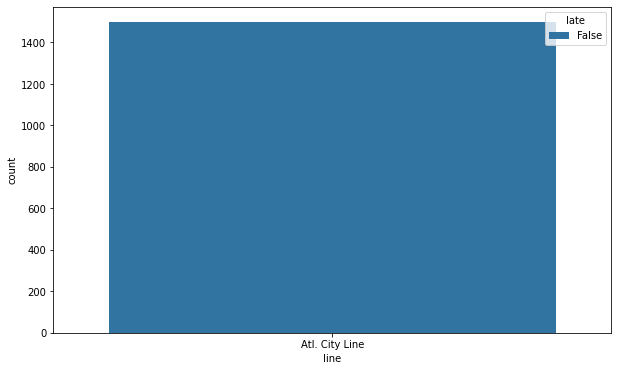

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(cluster5df['line'], hue=cluster5df['late'])

### Sixth Cluster Analysis

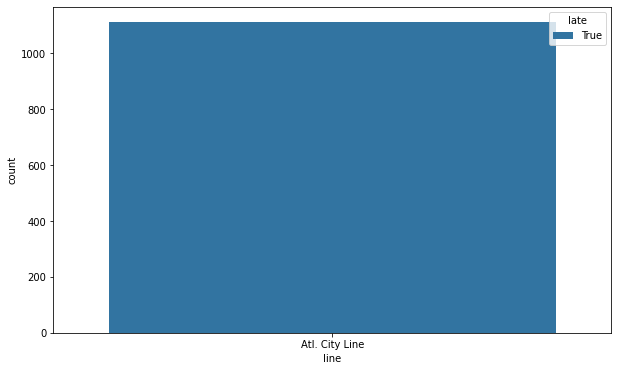

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(cluster6df['line'], hue=cluster6df['late'])

DBSCAN was able to correctly group late trains from the Atl. City line in this cluster.

### Seventh Cluster Analysis

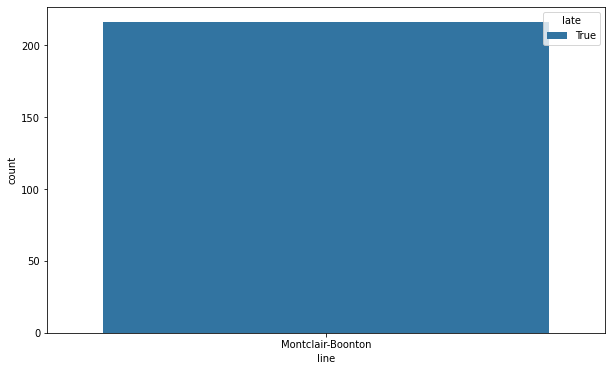

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(cluster7df['line'], hue=cluster7df['late'])

DBSCAN correctly grouped late trains again this time from the Pascack Valley and Montclair-Boonton lines.

### Eigth Cluster Analysis

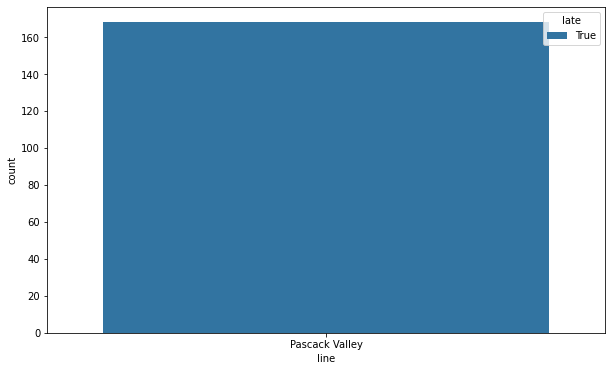

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(cluster8df['line'], hue=cluster8df['late'])

This cluster is also exclusively grouped with a true late status.

### Ninth Cluster Analysis

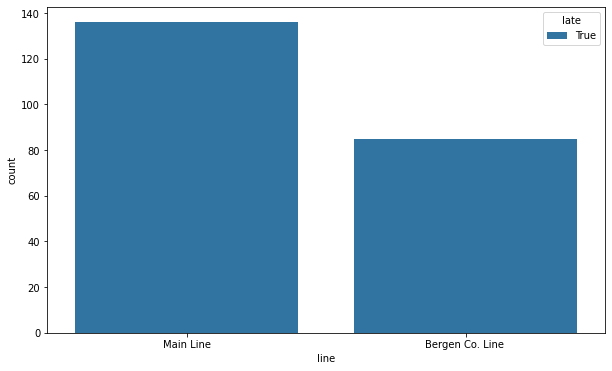

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(cluster9df['line'], hue=cluster9df['late'])

DBSCAN again grouped trains that were late into this cluster. In comparison to KMeans while the silhouette performance is reduced, the DBSCAN algorithm seems to be grouping trains better in regards to late status. While KMeans was grouping lines with both late and not late trains, DBSCAN seems to be grouping exclusively late or not late trains into certain clusters.

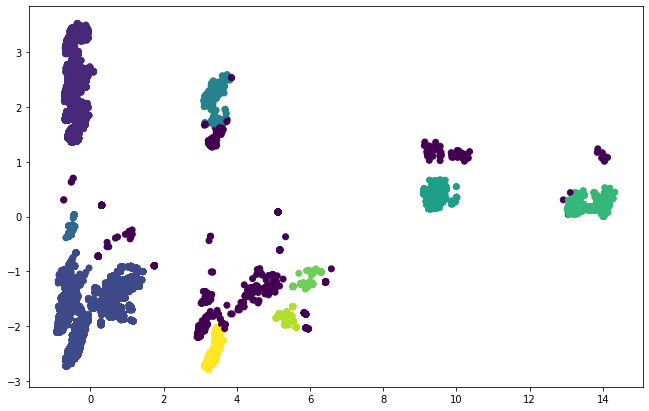

In [ ]:
# Visualizing DBSCAN clustering.
plt.figure(figsize=(11,7))
labels = dbscan_cluster.fit_predict(pca_components)
plt.scatter(PCA_components[0],PCA_components[1], c=labels); 
plt.show()

# t-SNE Dimensionality Reduction

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=1000)
tsne_results = tsne.fit_transform(pca_components)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 87172 samples in 0.068s...
[t-SNE] Computed neighbors for 87172 samples in 4.523s...
[t-SNE] Computed conditional probabilities for sample 1000 / 87172
[t-SNE] Computed conditional probabilities for sample 2000 / 87172
[t-SNE] Computed conditional probabilities for sample 3000 / 87172
[t-SNE] Computed conditional probabilities for sample 4000 / 87172
[t-SNE] Computed conditional probabilities for sample 5000 / 87172
[t-SNE] Computed conditional probabilities for sample 6000 / 87172
[t-SNE] Computed conditional probabilities for sample 7000 / 87172
[t-SNE] Computed conditional probabilities for sample 8000 / 87172
[t-SNE] Computed conditional probabilities for sample 9000 / 87172
[t-SNE] Computed conditional probabilities for sample 10000 / 87172
[t-SNE] Computed conditional probabilities for sample 11000 / 87172
[t-SNE] Computed conditional probabilities for sample 12000 / 87172
[t-SNE] Computed conditional probabilities for sa

Running and timing t-SNE. t-Distributed Stochastic Neighbor Embedding (t-SNE) is a newer method of dimensionality reduction like PCA. Unlike PCA it tries to minimize the Kullback–Leibler divergence (KL divergence) between the two dimensions which can allow for better visualization of high-dimensional data. 

### Applying KMeans to t-SNE

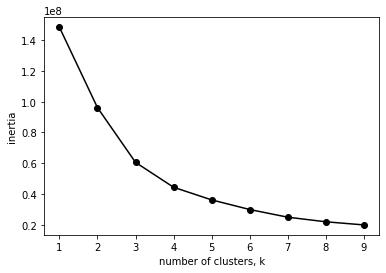

In [ ]:
# t-SNE reduced components stored in Pandas DataFrame.
tsne_components = pd.DataFrame(tsne_results)
# Defining range of k-values.
ks = range(1, 10)
inertias = []
for k in ks:
    # Create KMeans instance with k clusters: model.
    model = KMeans(n_clusters=k)
    # Fit model to samples.
    model.fit(tsne_components.iloc[:,:3])
    # Append the inertia to the list of inertias.
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Let's find examine our elbow to get a feel for the best k-value before we confirm it statistically with our silhouette score. 

In [ ]:
labels = KMeans(n_clusters=2, random_state=123).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.33156356


In [ ]:
labels = KMeans(n_clusters=3, random_state=123).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.36168802


Elbow method proves ineffective here as we have the highest silhouette score with a KMeans value of 3. 

In [ ]:
labels = KMeans(n_clusters=4, random_state=123).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.34889585


In [ ]:
labels = KMeans(n_clusters=5, random_state=123).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.3272132


In [ ]:
labels = KMeans(n_clusters=6, random_state=123).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.35432088


In [ ]:
labels = KMeans(n_clusters=7, random_state=123).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.35105142


In [ ]:
labels = KMeans(n_clusters=8, random_state=123).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.34030744


In [ ]:
labels = KMeans(n_clusters=9, random_state=123).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.33810344


In [ ]:
labels = KMeans(n_clusters=10, random_state=123).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.33230808


In [ ]:
# Defining the k-means with the best silhouette value (3) and timing it.
kmeans_cluster = KMeans(n_clusters=3, random_state=123)

# Fit model.
%timeit kmeans_cluster.fit(tsne_results)
y_pred = kmeans_cluster.predict(tsne_results)

1 loop, best of 3: 571 ms per loop


## KMeans Cluster Analysis with t-SNE

In [ ]:
# Attaching cluster labels to original dataframe.
df2['kmeans_tsne_cluster_label'] = kmeans_cluster.labels_

# Creating boolean arrays to pull clusters from original dataset.
cluster1 = df2['kmeans_tsne_cluster_label'] == 0
cluster2 = df2['kmeans_tsne_cluster_label'] == 1
cluster3 = df2['kmeans_tsne_cluster_label'] == 2

# Creating dataframe for each cluster found with KMeans and t-SNE.
cluster1df = df2[cluster1]
cluster2df = df2[cluster2]
cluster3df = df2[cluster3]

### First Cluster Analysis

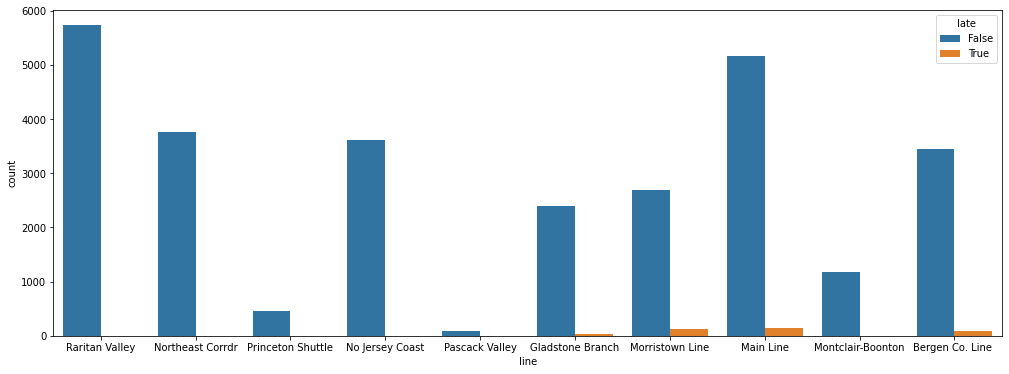

In [ ]:
plt.figure(figsize=(17,6))
sns.countplot(cluster1df['line'], hue=cluster1df['late'])

### Second Cluster Analysis

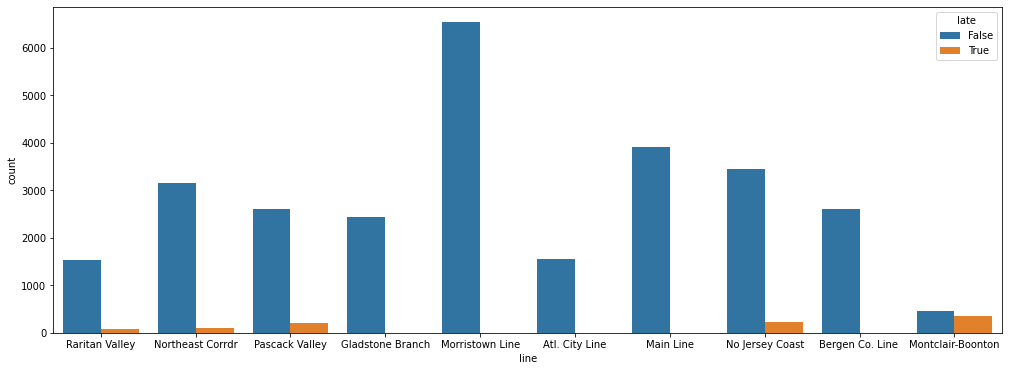

In [ ]:
plt.figure(figsize=(17,6))
sns.countplot(cluster2df['line'], hue=cluster2df['late'])

### Third Cluster Analysis

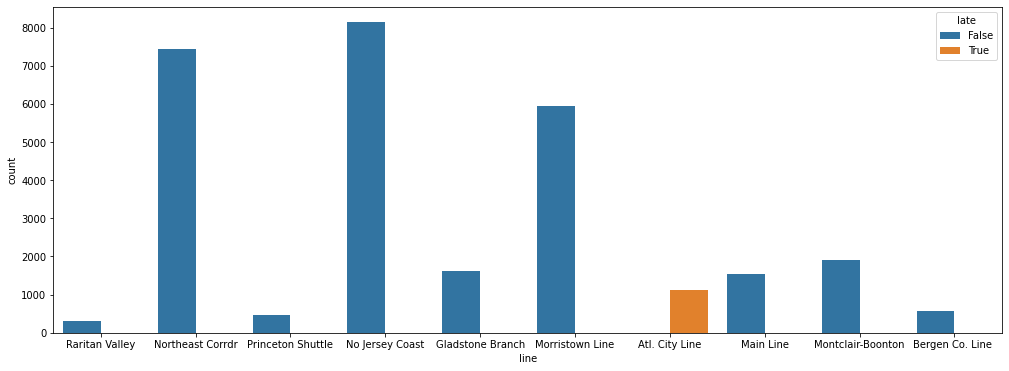

In [ ]:
plt.figure(figsize=(17,6))
sns.countplot(cluster3df ['line'], hue=cluster3df ['late'])

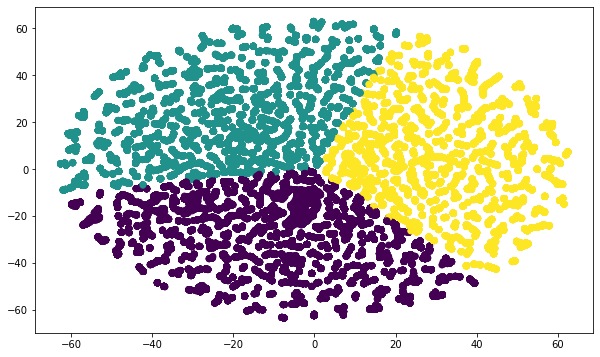

In [ ]:
# Finally, let's visualize the clusters formed by KMeans and t-SNE with a simple scatterplot.
plt.figure(figsize=(10,6))
plt.scatter(tsne_components[0],tsne_components[1], c=y_pred); 
plt.show()

The clustering seen here is very simple and does not conform to the reduced dimensional shape all too much. 

## Applying DBSCAN Clustering to t-SNE

In [ ]:
dbscan_cluster = DBSCAN(eps=.1, min_samples=50)
clusters = dbscan_cluster.fit_predict(tsne_results)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(tsne_results, clusters, metric='euclidean')))

The silhouette score of the DBSCAN solution: -0.39637717604637146


Defining the density based algorithm DBSCAN and adjusting the epsilon and minimum sample values. The silhouette score may hopefully be improved upon with different hyperparameter values as our DBSCAN clustering algorithm is performing significantly worse on t-SNE reduced features.

In [ ]:
dbscan_cluster = DBSCAN(eps=.1, min_samples=75)
clusters = dbscan_cluster.fit_predict(tsne_results)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(tsne_results, clusters, metric='euclidean')))

The silhouette score of the DBSCAN solution: -0.6989871859550476


Increased minimum sample size made performance even worse in our new clusters. Let's try adjusting epsilon value.

In [ ]:
dbscan_cluster = DBSCAN(eps=.2, min_samples=50)
clusters = dbscan_cluster.fit_predict(tsne_results)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(tsne_results, clusters, metric='euclidean')))

The silhouette score of the DBSCAN solution: -0.15399447083473206


Performance increased with epsilon value increase but it is still performing very poorly. Let's try increasing minimum sample value.

In [ ]:
dbscan_cluster = DBSCAN(eps=.2, min_samples=100)
clusters = dbscan_cluster.fit_predict(tsne_results)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(tsne_results, clusters, metric='euclidean')))

The silhouette score of the DBSCAN solution: -0.30197665095329285


It seems we need to minimize our minimum sample value instead, let's try a value of 2.

In [ ]:
dbscan_cluster = DBSCAN(eps=.2, min_samples=2)
clusters = dbscan_cluster.fit_predict(tsne_results)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(tsne_results, clusters, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.8923928737640381


Much better performance than our initial DBSCAN clusters, almost perfect clustering. Let's try a couple of other epsilon values to confirm this is the right choice.

In [ ]:
dbscan_cluster = DBSCAN(eps=.4, min_samples=2)
clusters = dbscan_cluster.fit_predict(tsne_results)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(tsne_results, clusters, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.8526838421821594


In [ ]:
dbscan_cluster = DBSCAN(eps=.3, min_samples=2)
clusters = dbscan_cluster.fit_predict(tsne_results)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(tsne_results, clusters, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.8938735127449036


In conclusion, we saw the best clustering performance with DBSCAN clustering using t-SNE reduced features with tuned hyperparameter values. By tuning these we were able to transform a poor clustering algorithm into one that outperformed our inital KMeans clustering algorithm. However, the number of clusters formed is significantly higher than with KMeans.

### DBSCAN Cluster Analysis with t-SNE

In [ ]:
# Finding the unique values listed in newly created DBSCAN clusters.
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

This clustering technique would prove valuable if we could find a specific cluster to target.

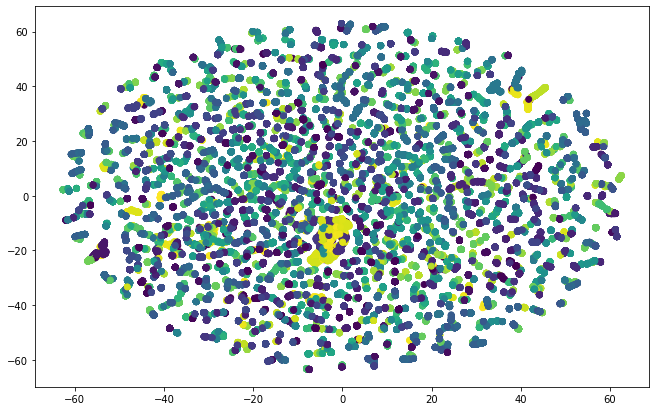

In [ ]:
# Visualizing DBSCAN clustering.
plt.figure(figsize=(11,7))
labels = dbscan_cluster.fit_predict(tsne_components)
plt.scatter(tsne_components[0],tsne_components[1], c=labels); 
plt.show()

The clustering seen here conforms more to the shape of reduced dimensional t-SNE data than the KMeans clustering which conforms more to the overall structure of the data. We have defined almost 43 individual clusters with a higher silhouette score showing that DBSCAN was able to more efficiently group data than KMeans although at a higher level of complexity. Further research could include different perplexity values to attempt reducing cluster number.

# Deep Learning

In [ ]:
# Create our target variable. 
y = df['late']

# Create X values by dropping our target from DataFrame.
X = df.drop(columns=['late'])

# Use pandas get_dummies function to create dummy variables necessary for statistical interpretation (One Hot Encoding).
X = pd.get_dummies(X)

# Implementing class balancing.
sm = SMOTE(sampling_strategy='minority', random_state=42)

X, y = sm.fit_resample(X, y)

# Scaling data.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Splitting data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# Timing model.
start_time = time.time()
# Initiate sequential deep learning model.
model = Sequential()
# Create first dense layer, with input shape equal to DataFrame dimensions.
model.add(Dense(128, input_shape=(790,), activation="relu"))
# Creating second dense layer with sigmoid activation for classification task.
model.add(Dense(64, activation='sigmoid'))
# Creating third output layer with sigmoid activation for classification task.
model.add(Dense(1, activation="sigmoid"))
# Compiling model with adam optimizer and binary_crossentropy for clasification task.
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
# Fitting model to training data.
model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1)
# Print model time.
print("--- %s seconds ---" % round(time.time() - start_time, 3))

Epoch 1/20
1059/1059 [==============================] - 3s 3ms/step - loss: 0.2030 - accuracy: 0.9053
Epoch 2/20
1059/1059 [==============================] - 3s 3ms/step - loss: 0.1261 - accuracy: 0.9414
Epoch 3/20
1059/1059 [==============================] - 3s 3ms/step - loss: 0.1042 - accuracy: 0.9504
Epoch 4/20
1059/1059 [==============================] - 3s 3ms/step - loss: 0.0912 - accuracy: 0.9569
Epoch 5/20
1059/1059 [==============================] - 3s 3ms/step - loss: 0.0836 - accuracy: 0.9609
Epoch 6/20
1059/1059 [==============================] - 3s 3ms/step - loss: 0.0762 - accuracy: 0.9644
Epoch 7/20
1059/1059 [==============================] - 3s 3ms/step - loss: 0.0730 - accuracy: 0.9662
Epoch 8/20
1059/1059 [==============================] - 3s 3ms/step - loss: 0.0685 - accuracy: 0.9683
Epoch 9/20
1059/1059 [==============================] - 3s 3ms/step - loss: 0.0661 - accuracy: 0.9697
Epoch 10/20
1059/1059 [==============================] - 3s 3ms/step - loss: 0.063

Creating first and second dense layers with the first layer being a relu layer. The second and final output layers will be sigmoid for the classification task at hand. We will also set the optimizer to Adam an adaptive learning rate optimization algorithm. Setting verbose to 1 prints out results after each epoch to track progress.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0572957880795002
Test accuracy: 0.9758171439170837


The test score for our deep learning model is almost perfect and test accuracy is also showing high performance.

In [ ]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred.round())
cm = confusion_matrix(y_test, y_pred.round(), normalize=None)

print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
              precision    recall  f1-score   support

       False       0.96      0.99      0.98     16804
        True       0.99      0.96      0.98     17063

    accuracy                           0.98     33867
   macro avg       0.98      0.98      0.98     33867
weighted avg       0.98      0.98      0.98     33867

Confusion matrix:
[[16669   135]
 [  684 16379]]


Classification report shows no signs of over or underfitting and is also showing high performance for deep learning model.

# Conclusion

In conclusion a couple of supervised models stood out as top performers. This included the decision tree model with SelectKBest selected features which had .96 accuracy score and 4.3 second run time and KNN classifier using PCA feature decomposition with the best combination of run time and performance at 6 seconds and .96 accuracy score also. Decision tree classifier with PCA decomposed features performed best in terms of scoring with an accuracy score of.98 but at the cost of a longer run time of 44 seconds.

Our unsupervised learning model using DBSCAN and t-SNE reduced features was able to cluster the data very effectively with a silhouette scoring of almost perfect at .89. Cluster analysis showed finely tuned clusters numbering 43. KMeans clustering algorithms were less effective on t-SNE and PCA reduced data but by only a little using PCA. We had scoring as high as .80 on KMeans clustered data using a KMeans cluster value of 4. This shows two different effective approaches to clustering, one displaying highly selective numerous cluster numbers seen with DBSCAN and t-SNE and the other showing broad clustering with a cluster number of 4 using KMeans and PCA data.

TensorFlow deep learning models also offered comparable performance in classification report metrics to decision tree classifier with PCA but at a longer runtime of 65 seconds. Future research could reduce the deep learning model's run time by optimizing the number of epochs or adjusting batch size and minimizing the impact on scoring. 